**Author:**
Jean Paul Azzopardi

**Dates:**
March - November 2023

# **Instructions:**

The cells below contain code that connects to the MassCourt MySQL database.

The tables should be visible as is. If not, navigate to 'Runtime' above and press 'Run all.'

The notebook will execute accordingly - **it will take some time (~5 to 10 minutes)**. After the intial run, the data will be cached so it won't take as long to load again.

Once done, you will be able to see interactive tables (if not available click the magic wand next to the table and it will make it interactive). Please note the tables are limited to 200,000 rows, even though queries may intend to return more. You can filter and order as you would in an Excel file.



In [2]:
!pip install pymysql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 700.5 kB/s eta 0:00:00


In [3]:
import pymysql
import pandas as pd
import numpy as np
from google.colab import data_table

In [4]:
data_table.enable_dataframe_formatter()

In [5]:
#Connect to MySQL database

cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                              host='masscourtsplus.org',
                              database='wp_courtdocs') #REMEMBER LOGIN


cursor = cnx.cursor()
# more info here: https://docs.google.com/document/d/1aZKF0X7HjcXUYurD8uQYDpgo9wQdeJH4CMviBJeTYVc/edit#

In [6]:

query =  """
DESCRIBE cdocs_case_action_index;|

"""

# **TABLE 9: CASELOAD PER COURT, Grouped By Year**

In [7]:
# How many cases have been filed each year over the last ten years in each court?
query =  """
    SELECT
        SUBSTRING(file_date, 1, 4) AS case_year,
        wp_terms.name AS court,
        COUNT(*) AS count
    FROM
        cdocs_case_meta_index AS cdocs_meta
            JOIN
        wp_terms ON wp_terms.term_id = cdocs_meta.court_term_id -- joining court
            JOIN
        wp_term_taxonomy ON wp_term_taxonomy.term_id = cdocs_meta.court_term_id
            JOIN
        wp_terms t1 ON t1.term_id = wp_term_taxonomy.parent -- joining parent court
    WHERE
        t1.name LIKE '%District%'
        AND SUBSTRING(file_date, 1, 4) >= '2014'
    GROUP BY
        SUBSTRING(file_date, 1, 4), wp_terms.name, t1.name
    ORDER BY
        case_year ASC, count DESC;

      """



%time
cursor.execute(query) # executing query

results = cursor.fetchall() # fetching result

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [8]:
case_per_court_by_year = pd.DataFrame(results)
case_per_court_by_year.rename({0:'Year', 1:'Court',2:'Count'}, axis = 1)

,Year,Court,Count
0,2014,Quincy,8266
1,2014,Springfield,7445
2,2014,Worcester,7060
3,2014,Lowell,6317
4,2014,Brockton,5605
...,...,...,...
677,2024,Ipswich,53
678,2024,Natick,52
679,2024,Brookline,49
680,2024,Edgartown,31


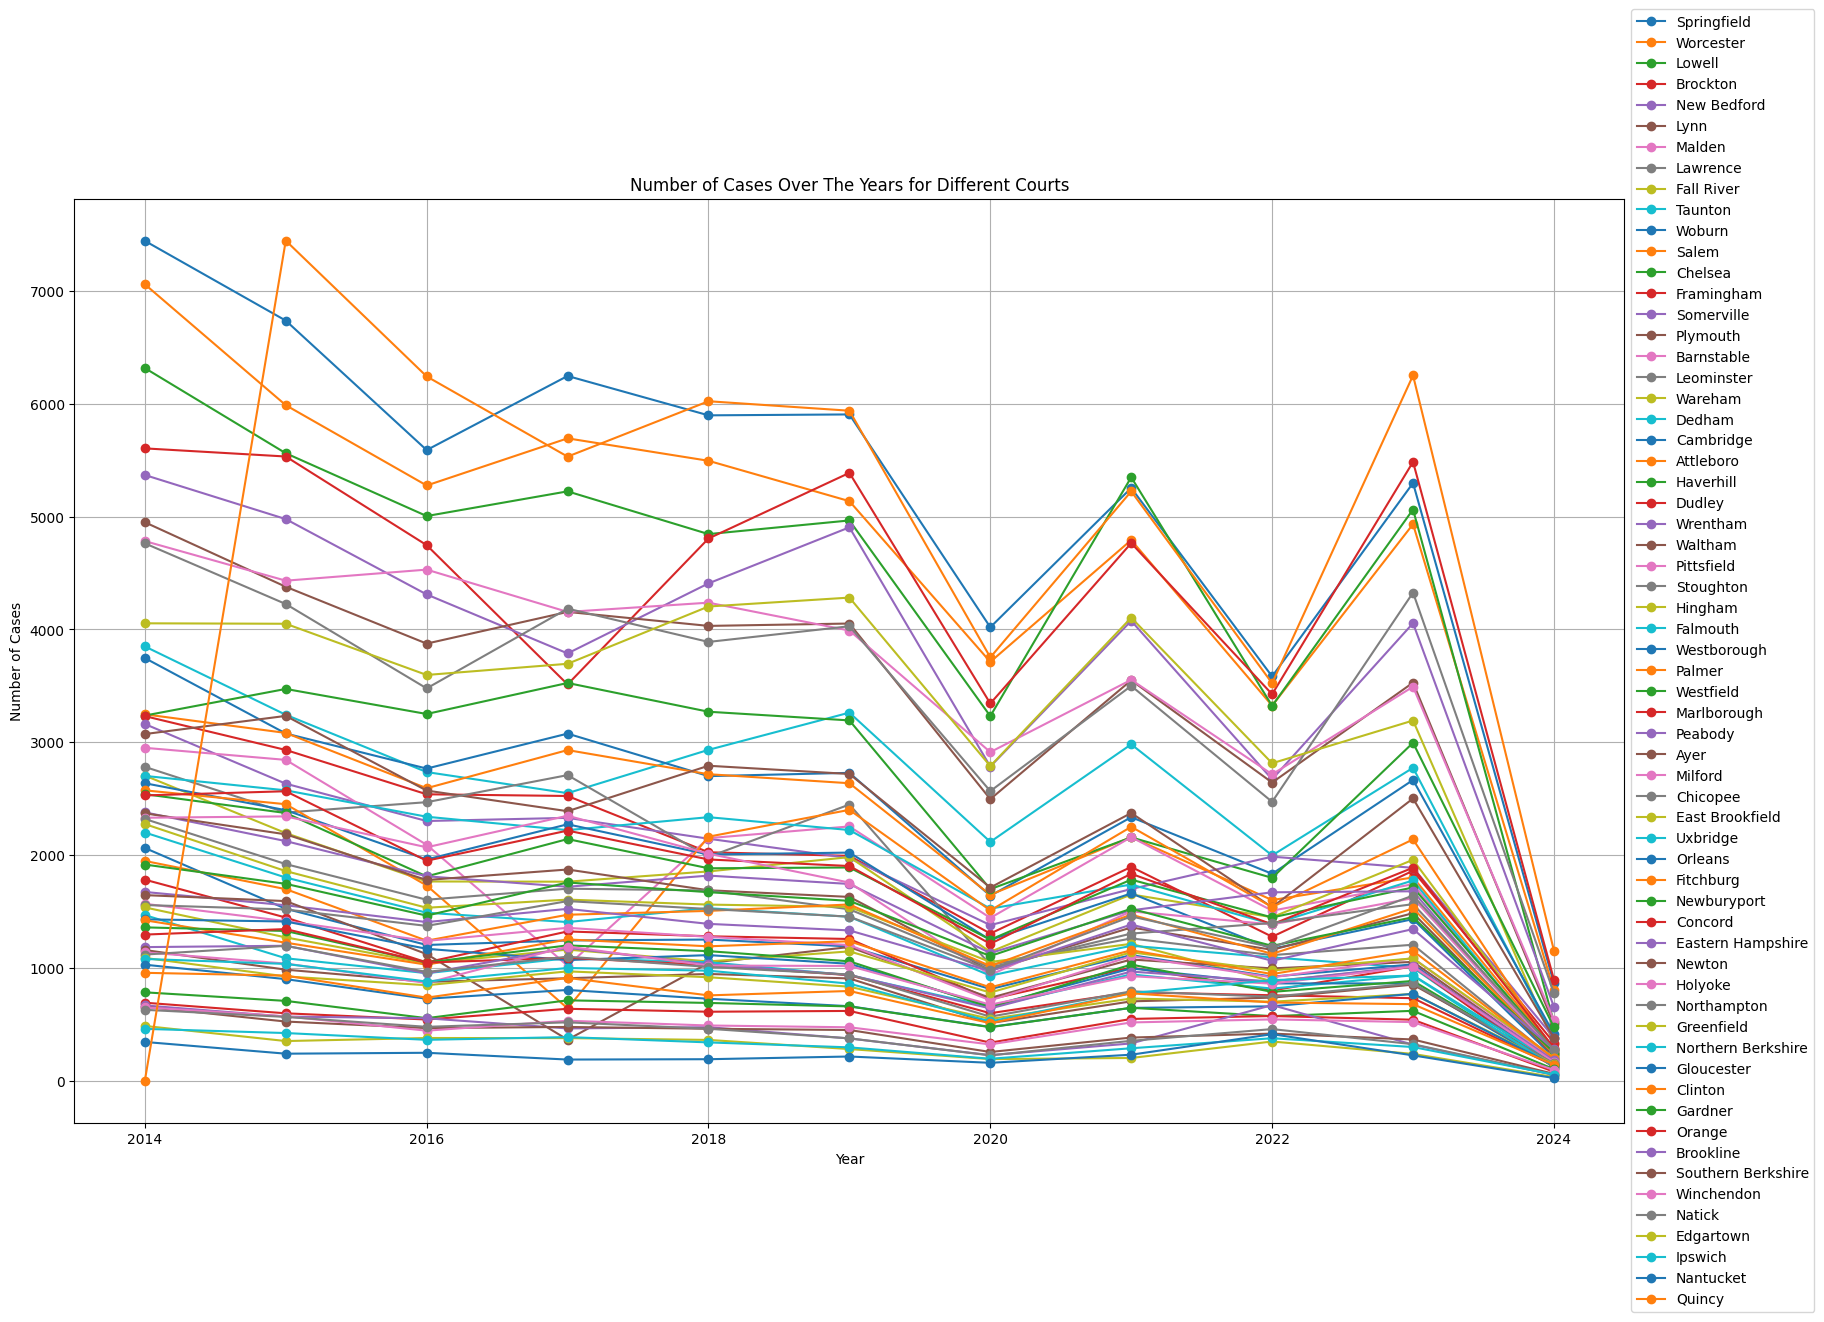

In [108]:
import numpy as np
import matplotlib.pyplot as plt



def organize(x):
  #Obtains the maximum/minimum year and an array filled with all years in between
  min_y = int(x[1][0])
  max_y = int(x[-1][0])
  years_arr = np.linspace(min_y, max_y, (max_y - min_y + 1),dtype=int)
  court_count = {}
  for i in range(1,len(x)):
    #iterates through the table
    court = x[i][1]
    index = abs((min_y - int(x[i][0])))
    if court not in court_count:
      #Creates a new dictionary reference with an arr len == years_arr
      court_count[court] = ([-1] * len(years_arr))
      court_count[court][index] = x[i][-1]
    else:
      #updates the existing dictionaries
      court_count[court][index] = x[i][-1]
  return years_arr, court_count

def line_graph(years_arr, court_count):
    # Plotting the data for each court
    plt.figure(figsize=(20, 12))
    for court, counts in court_count.items():
        plt.plot(years_arr, counts, marker='o', linestyle='-', label=court)

    # Adding titles and labels
    plt.title('Number of Cases Over The Years for Different Courts')
    plt.xlabel('Year')
    plt.ylabel('Number of Cases')

    # Adding legend
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Adding grid
    plt.grid(True)

    # Show plot
    plt.show()


years_arr, court_count = organize(results)
line_graph(years_arr, court_count)

Note:
Data is incomplete for 2024

There was a total of 1167365 cases in the last ten years



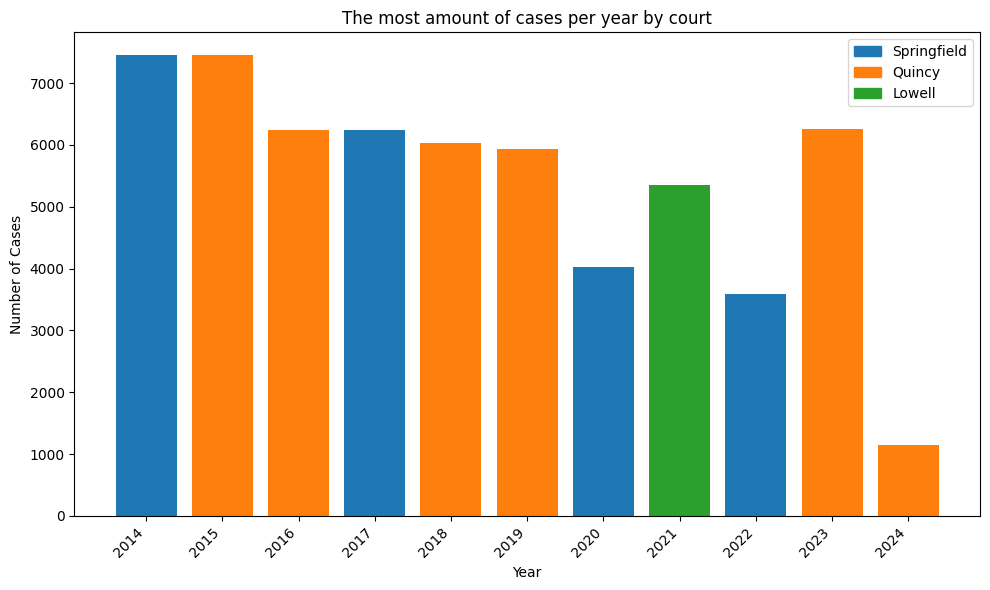

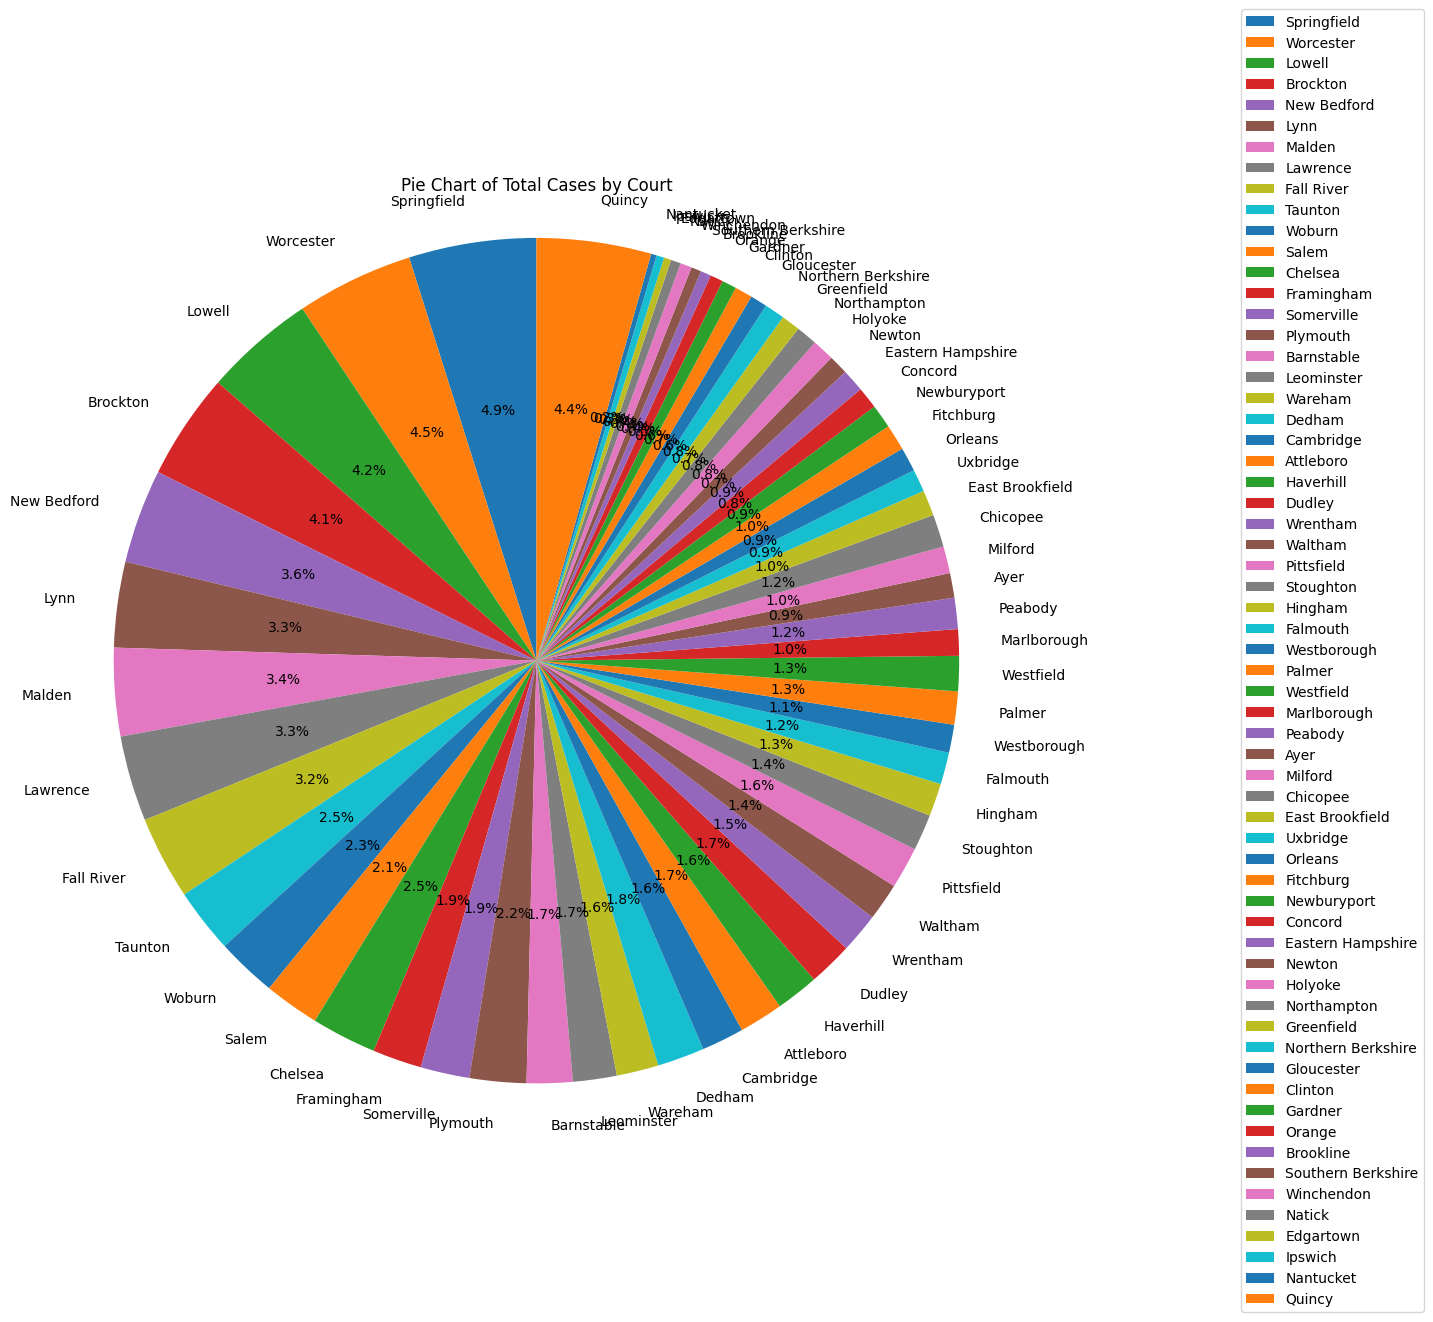

In [106]:
import matplotlib.pyplot as plt

class Stat:
    def __init__(self, years_arr, court_count):
        self.years_arr = years_arr
        self.court_count = court_count

    def total_cases(self):
        total = sum(sum(counts) for counts in self.court_count.values())
        return total

    def most_cases_per_court_per_year(self):
        most = {}
        for y in range(len(self.years_arr)):
            year = self.years_arr[y]
            m = 0
            year_i = abs(self.years_arr[0] - year)
            court = ""

            for key in self.court_count:
                if self.court_count[key][year_i] > m:
                    court = key
                    m = self.court_count[key][year_i]
            most[year] = [court, m]
        return most

    def print_most_cases_per_court_per_year(self):
        # Call the method most_cases_per_court_per_year and prints the results
        x = self.most_cases_per_court_per_year()
        for key in x:
            print("The most cases in", str(key), "is", str(x[key][0]), "with", x[key][-1], "cases")
            print()

    def average_amount_cases_per_court(self):
        average = {}
        for key in self.court_count:
            # Iterates through all the courts
            avg = 0
            for v in range(len(self.court_count[key])):
                avg += self.court_count[key][v]
            avg = int(avg/len(self.court_count[key]))
            average[key] = avg
        return average

    def print_average_cases_per_court_per_year(self):
        # Call the method most_cases_per_court_per_year and prints the results
        x = self.average_amount_cases_per_court()
        for key in x:
            print("The average amount of cases in the last 10 years for", str(key), "is", str(x[key]), "cases")
            print()

    def bar_graph_most(self, dic, title, x_axis, y_axis):
        # Inputs a dic, title's for graph, x_axis and y_axis
        x = list(dic.keys())
        y = list(dic.values())
        print(x)
        print(y)
        return 0

    def bar_graph_average(self, data, title, x_axis, y_axis):
        # Inputs a dic, title's for graph, x_axis and y_axis
        years = list(data.keys())
        x_axis =  list(data.keys())
        y =  list(data.values())
        return 0
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(x, y)
        plt.title(title)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def pie_chart_sum_total(self):
        x = list(self.court_count.keys())
        y = list(self.court_count.values())
        print(y)

    def bar_graph_most(self, dic, title, x_axis, y_axis):
        # Extracting data
        x = list(dic.keys())
        y = list(dic.values())
        label = [-1] * len(y)
        colors = {}

        # Extracting labels and values
        for i in range(len(y)):
            # Splitting up the tuples in dic.values
            label[i] = y[i][0]
            y[i] = y[i][-1]
            # Assigning unique color for each label
            if label[i] not in colors:
                colors[label[i]] = plt.cm.tab10(len(colors))
        # Plotting
        plt.figure(figsize=(10, 6))
        bars = plt.bar(x, y, color=[colors[l] for l in label])
        plt.title(title)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.xticks(x, rotation=45, ha='right')  # Using years as x-axis labels
        plt.tight_layout()

        # Creating legend
        legend_handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in colors]
        plt.legend(legend_handles, colors.keys())

        # Show plot
        plt.show()

    def bar_graph_average(self, data, title, x_axis, y_axis):
        years = list(data.keys())
        x = list(data.keys())
        y = list(data.values())

        plt.figure(figsize=(10, 6))
        plt.bar(x, y)
        plt.title(title)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def pie_chart_sum_total(self):
        w = self.court_count
        l = len(self.court_count)
        k = [-1] * l
        a = 0
        for key in w:
            k[a] = sum(w[key])
            a += 1
        labels = list(self.court_count.keys())
        plt.figure(figsize=(12, 12))
        plt.pie(k, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})  # Adjust label fontsize
        plt.axis('equal')
        plt.title('Pie Chart of Total Cases by Court')
        plt.legend(loc='best', fontsize='small', title='Courts', title_fontsize='small')  # Adjust legend fontsize
        # Adding legend
        plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

        # Adding grid
        plt.grid(True)
        plt.show()



# Execute
years_arr, court_count = organize(results)
# Creating an instance of the Stat class
statistics = Stat(years_arr, court_count)

# Getting total cases in the last 10 years
total_cases = statistics.total_cases()
print("There was a total of", str(total_cases), "cases in the last ten years")
print()

# Graphs
# Most cases per year
title = "The most amount of cases per year by court"
x_axis = "Year"
y_axis = "Number of Cases"



statistics.bar_graph_most(statistics.most_cases_per_court_per_year(),title,x_axis,y_axis)

# Average amount of cases
title2 = "Average amount of cases over the last ten years"
x_axis2 = "Court"
y_axis2 = "Average Number of Cases"


#Finish at a later date
#statistics.bar_graph_average(statistics.average_amount_cases_per_court(),title2,x_axis2,y_axis2)

# Sum total of cases
statistics.pie_chart_sum_total()



# Prints()
  # Average case number over the last ten y
# statistics.print_average_cases_per_court_per_year()

  # Most in the last ten years
# statistics.print_most_cases_per_court_per_year()


#**Close Connection MYSQL server**

In [ ]:
cursor.close() # closing connection to MySQL server

cnx.close() # closing connection to MySQL server